In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [8]:
def FindCorners(source, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(source)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        #print(ret)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

def CalibrateCamera(objpoints, imgpoints, img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist

def UnDistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradi = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(gradi)
    binary_output[(gradi >= thresh[0]) & (gradi <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_threshold(img, s_thresh=(170, 255), v_thresh=(170, 255)):
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #l_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    #h_channel = hsv[:,:,0]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) & (v_binary == 1)] = 1
    
    return combined_binary

def video_threshold(undistorted, b_thresh=(140, 200), l_thresh=(210, 255)):
    b_channel = cv2.cvtColor(undistorted, cv2.COLOR_RGB2Lab)[:,:,2]
    #l_channel = cv2.cvtColor(undistorted, cv2.COLOR_RGB2LUV)[:,:,0] 
    l_channel = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)[:,:,1]
    
    # Set the upper and lower thresholds for the b channel

    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    #write_name = 'test_video/lcsen'+str(left_lline.count)+'.jpg'
    #cv2.imwrite(write_name,l_binary)
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 255
    
    return combined_binary

def Unwarp(bin_img):
       
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
   
        
    img_size = (bin_img.shape[1], bin_img.shape[0])
    
    bot_width = .83
    mid_width = .23
    height_pct = .67
    bottom_trim = .93
    offset = img_size[0]*.03
    
    src = np.float32([[bin_img.shape[1]*(.5-mid_width/2),bin_img.shape[0]*height_pct],[bin_img.shape[1]*(.5+mid_width/2),bin_img.shape[0]*height_pct],[bin_img.shape[1]*(.5+bot_width/2),bin_img.shape[0]*bottom_trim],[bin_img.shape[1]*(.5-bot_width/2),bin_img.shape[0]*bottom_trim]])
    
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(bin_img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped, Minv

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    #plt.imshow(warped)
    #plt.show()
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    #plt.plot(l_sum)
    #plt.show()
    #r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_sum = np.sum(warped[int(2*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    #plt.plot(r_sum)
    #plt.show()
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        #print('first: ', level)
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        
        conv_signal = np.convolve(window, image_layer)
        #print(conv_signal.shape)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        #print(l_min_index,l_max_index )
        if np.argmax(conv_signal[l_min_index:l_max_index]>10000) > 0:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        if np.argmax(conv_signal[r_min_index:r_max_index]>10000) > 0:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def find_window_centroids_noblind(warped, window_width, window_height, margin, l_allx, r_allx):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    #print(len(l_allx), len(r_allx))
    # Go through each layer looking for max pixel locations
    for level in range(0,(int)(warped.shape[0]/window_height)):
        #print('first: ', level)
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        #print(conv_signal.shape)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_center = int(np.average(l_allx[::-1][level*window_height:(level+1)*window_height]))
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        
        #print(l_min_index,l_max_index )
        if np.argmax(conv_signal[l_min_index:l_max_index]>10000) > 0:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
        # Find the best right centroid by using past right center as a reference
        r_center = int(np.average(r_allx[::-1][level*window_height:(level+1)*window_height]))
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        #print(level, np.argmax(conv_signal[r_min_index:r_max_index]), np.amax(conv_signal[r_min_index:r_max_index]))
        #plt.plot(image_layer)
        #plt.show()
        if np.argmax(conv_signal[r_min_index:r_max_index]>10000) > 0:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

#def check_parallel(leftx, rightx):
#    margin_pct = .5
#    for i in range(0,len(leftx)):
        
        

In [9]:
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y
source_path = "camera_cal/"
cal_objpoints = []
cal_imgpoints = []

source = 'camera_cal/calibration*.jpg'

cal_objpoints, cal_imgpoints = FindCorners(source, nx, ny)


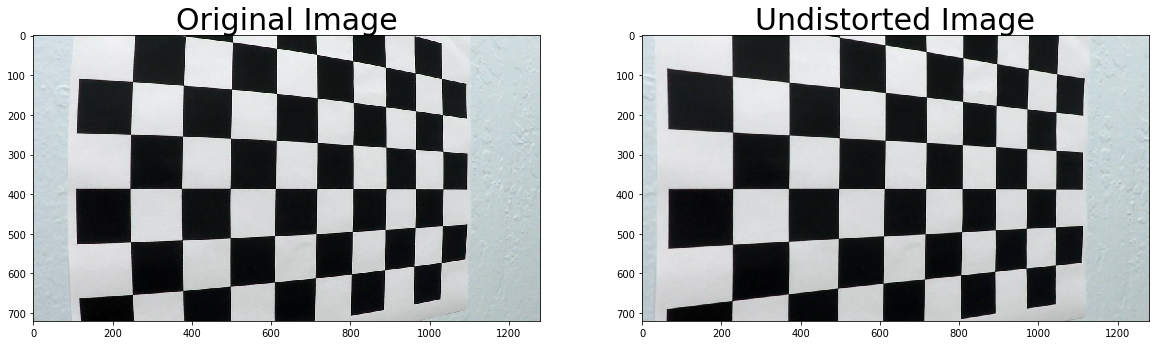

In [10]:
img = cv2.imread('camera_cal/calibration5.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist = CalibrateCamera(cal_objpoints, cal_imgpoints, img)


dst = UnDistort(img, mtx, dist)
cv2.imwrite('camera_cal/undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
"""dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )"""
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [11]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.count = 0

In [6]:
images = glob.glob('test_images/test*.jpg')
#images = glob.glob('frame*.jpg')
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
    # Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = UnDistort(img, mtx, dist)
    write_name = 'test_images/undist'+str(idx)+'.jpg'
    cv2.imwrite(write_name,dst)
     # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', thresh=(20, 255))
    grady = abs_sobel_thresh(dst, orient='y', thresh=(20, 255))
    #mag_binary = mag_thresh(dst, sobel_kernel=9, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))

    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    binary_image = np.zeros_like(dst[:,:,0])
    
    color_bin = color_threshold(dst,s_thresh=(90, 255), v_thresh=(80, 255))
    binary_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 255
    #binary_image[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) | (color_bin == 1))] = 255
    
    
    write_name = 'test_images/binary'+str(idx)+'.jpg'
    cv2.imwrite(write_name,binary_image)
    
    warped, Minv = Unwarp(binary_image)
    write_name = 'test_images/warped'+str(idx)+'.jpg'
    cv2.imwrite(write_name,warped)
    
    leftx = []
    rightx = []
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            #print(window_centroids[level][0])
            #print(window_centroids[level][1])

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        write_name = 'test_images/markedwarped'+str(idx)+'.jpg'
        cv2.imwrite(write_name,output)
                
        yvals = range(0,warped.shape[0])
        res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
        
        
        left_fit = np.polyfit(res_yvals, leftx, 2)
        left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
        
        right_fitx = np.array(right_fitx, np.int32)
                
        left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        
        road = np.zeros_like(dst)
        road_bkg = np.zeros_like(dst)
        cv2.fillPoly(road,[left_lane], color=[0,255, 0])
        cv2.fillPoly(road, [right_lane], color = [0,255, 0])
        cv2.fillPoly(road_bkg,[left_lane], color=[255,255, 255])
        cv2.fillPoly(road_bkg, [right_lane], color = [255,255, 255])
        
        newwarp = cv2.warpPerspective(road, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        newwarp_bkg = cv2.warpPerspective(road_bkg, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        
        base = cv2.addWeighted(dst, 1.0 , newwarp_bkg, -1.0, 0)
        result = cv2.addWeighted(base, 1.0 , newwarp, 1.0, 0)
        
        left_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        right_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*yvals[-1]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        camera_center = (left_fitx[-1]+right_fitx[-1])/2
        #print(camera_center)
        center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'
            
        cv2.putText(result,'Left Curvature = '+str(round(left_curverad,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Right Curvature = '+str(round(right_curverad,3))+'(m)',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Vehicle is = '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    write_name = 'test_images/MarkedImage'+str(idx)+'.jpg'
    
    cv2.imwrite(write_name,result)
    #histogram = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    #plt.plot(histogram)
    #histogram2 = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    #plt.plot(histogram2)
    #print(left_fitx)
    #yy = np.full_like(left_fitx,'700')
    #plt.plot(left_fitx, yy, 'o', color='red', markersize=3)

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
def process(img):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    undistorted = UnDistort(img, mtx, dist)
    
    #warped, Minv = Unwarp(undistorted)
    
    
    #combined_binary = video_threshold(undistorted, (145,200), (215, 255))
    
# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undistorted, orient='x', thresh=(20, 255))
    grady = abs_sobel_thresh(undistorted, orient='y', thresh=(20, 255))
    #mag_binary = mag_thresh(dst, sobel_kernel=9, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))

    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    combined_binary = np.zeros_like(undistorted[:,:,0])
    
    color_bin = color_threshold(undistorted,s_thresh=(90, 255), v_thresh=(80, 255))
    combined_binary[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 255
    
    #apply_thresholds(dst)
    warped, Minv = Unwarp(combined_binary)
    #warped = binwarped
    #write_name = 'test_video/binwarped'+str(left_lline.count)+'.jpg'
    #cv2.imwrite(write_name,combined_binary)
    
    leftx = []
    rightx = []
    window_centroids = []
    
    if left_lline.detected == True and right_lline.detected == True:  
        window_centroids = find_window_centroids_noblind(warped, window_width, window_height, margin, left_lline.allx, right_lline.allx)
    
    
    if len(window_centroids) == 0 or left_lline.detected == False and right_lline.detected == False:
        window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
        # If we found any window centers
    if len(window_centroids) > 0:

        for level in range(0,len(window_centroids)):
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
                
        #print(str(left_lline.count))
        #left_lline.count += 1
        yvals = range(0,warped.shape[0])
        res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
        #print(leftx)
        #print(res_yvals)
        left_fit = np.polyfit(res_yvals, leftx, 2)
        left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        if len(left_fitx) > 0:
            left_lline.detected = True
        else:
            left_lline.detected = False

        left_lline.diffs = left_lline.current_fit - left_fit
        left_lline.current_fit = left_fit
        left_lline.allx = left_fitx
        left_lline.ally = yvals

        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)
        if len(right_fitx) > 0:
            right_lline.detected = True
        else:
            right_lline.detected = False

        right_lline.diffs = right_lline.current_fit - right_fit
        right_lline.current_fit = right_fit
        right_lline.allx = right_fitx
        right_lline.ally = yvals

        left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

        road = np.zeros_like(undistorted)
        #road_bkg = np.zeros_like(dest)
        cv2.fillPoly(road,[left_lane], color=[0, 255, 0])
        cv2.fillPoly(road, [right_lane], color = [0, 255, 0])
        cv2.fillPoly(road, [middle_marker], color = [0,255, 0])
        #cv2.fillPoly(road_bkg,[left_lane], color=[255,255, 255])
        #cv2.fillPoly(road_bkg, [right_lane], color = [255,255, 255])

        newwarp = cv2.warpPerspective(road, Minv, (undistorted.shape[1], undistorted.shape[0]),flags=cv2.INTER_LINEAR)
        #newwarp_bkg = cv2.warpPerspective(road_bkg, Minv, (dest.shape[1], dest.shape[0]),flags=cv2.INTER_LINEAR)

        #base = cv2.addWeighted(dest, 1.0 , newwarp_bkg, -1.0, 0)
        result = cv2.addWeighted(undistorted, 1.0 , newwarp, 0.3, 0)

        left_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        right_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
            # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*yvals[-1]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        left_lline.radius_of_curvature = left_curverad
        right_lline.radius_of_curvature = right_curverad

        avg_curverad = (left_curverad + right_curverad)/2
        camera_center = (left_fitx[-1]+right_fitx[-1])/2
        center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix

        left_lline.line_base_pos = center_diff
        right_lline.line_base_pos = center_diff

        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        cv2.putText(result,'Curvature = '+str(round(avg_curverad,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        #cv2.putText(result,'Right Curvature = '+str(round(right_curverad,3))+'(m)',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Vehicle is = '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

            #result = output

        return result

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_lline = Line()
right_lline = Line()

OutputVideo = 'output.mp4'
InputVideo = 'project_video.mp4'

clip = VideoFileClip(InputVideo)
#clip = VideoFileClip(InputVideo).subclip(35,45)
#clip.save_frame("frame09.jpg", t=9)
#clip.save_frame("frame40.jpg", t=40)
#img = cv2.imread('frame.jpg')
#result = process(img)

#write_name = 'sl_curve.jpg'

#cv2.imwrite(write_name,result)
    
video_clip = clip.fl_image(process)

video_clip.write_videofile(OutputVideo, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:47<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

